В этом ноутбуке был проведен эксперемент по уменьшению количества варианта оценок с 5 до 4.

1 -> 1
2 -> 2
3 - с вероятностью 50/50 либо в двойку, либо оставалась тройкой
4 -> 3
5 -> 4

Зачем это надо было делать?

Я считаю, что 5 вариантов трудно интерпертировать человеку и эксперту. С 1 и 5 все понятно, либо ужасно, либо отлично, но как отличается 2 от 3 и 3 от 4, чтобы при этом 2 и 4 отличались значительно?

Если сделать по данному подходу, то оказывается, что средная абсолютная ошибка значительно меньше, чем при пяти вариантах, что может подтвержать теорию о субъективности оценок в диапазоне от 2 до 4, но нужно больше данных.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost.utils import eval_metric
from catboost import CatBoostRegressor, Pool
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import shap
import random
%matplotlib inline

Загрузка данных

In [2]:
df = pd.read_csv('../../corpus/calculated_metrics.csv', index_col=0)
df

,true_mask_path,pred_mask_path,review,true_mask_pixels,pred_mask_pixels,DICE,JACRD,AUC,KAPPA,RNDIND,...,PRCISON,FMEASR,ACURCY,FALLOUT,TP,FP,TN,FN,REFVOL,SEGVOL
0,dataset/Expert/00000072_000_expert.png,dataset/sample_1/00000072_000_s1.png,1,0,2121,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0
1,dataset/Expert/00000150_002_expert.png,dataset/sample_1/00000150_002_s1.png,5,2729,959,0.520065,0.351411,0.675705,0.519415,0.996630,...,1.000000,0.520065,0.998312,0.000000,959,0,1045847,1770,2729,959
2,dataset/Expert/00000181_061_expert.png,dataset/sample_1/00000181_061_s1.png,4,62059,173279,0.519559,0.350949,0.935726,0.473689,0.807597,...,0.352818,0.519559,0.892172,0.113676,61136,112143,874374,923,62059,173279
3,dataset/Expert/00000211_019_expert.png,dataset/sample_1/00000211_019_s1.png,4,138819,251580,0.708670,0.548791,0.936005,0.648735,0.806597,...,0.549853,0.708670,0.891534,0.124482,138332,113248,796509,487,138819,251580
4,dataset/Expert/00000211_041_expert.png,dataset/sample_1/00000211_041_s1.png,3,124276,285638,0.562957,0.391747,0.872117,0.476487,0.716678,...,0.403945,0.562957,0.829149,0.184200,115382,170256,754044,8894,124276,285638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,dataset/Expert/00011237_006_expert.png,dataset/sample_3/00011237_006_s3.png,3,39847,70040,0.519079,0.350511,0.837288,0.494596,0.904282,...,0.407196,0.519079,0.949601,0.041161,28520,41520,967209,11327,39847,70040
176,dataset/Expert/00011269_019_expert.png,dataset/sample_3/00011269_019_s3.png,1,3351,60618,0.000000,0.000000,0.471002,0.000000,0.885432,...,0.000000,0.000000,0.938994,0.057995,0,60618,984607,3351,3351,60618
177,dataset/Expert/00011355_011_expert.png,dataset/sample_3/00011355_011_s3.png,4,39493,195195,0.304123,0.179331,0.872778,0.257612,0.737018,...,0.182827,0.304123,0.844252,0.158072,35687,159508,849575,3806,39493,195195
178,dataset/Expert/00011450_000_expert.png,dataset/sample_3/00011450_000_s3.png,4,49848,9603,0.315453,0.187263,0.593943,0.304776,0.925389,...,0.976466,0.315453,0.961188,0.000226,9377,226,998502,40471,49848,9603


<AxesSubplot:>

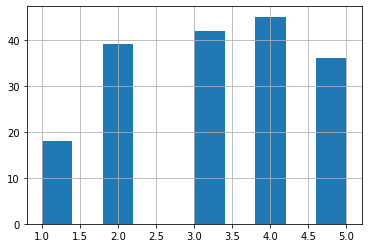

In [4]:
df['review'].hist()

Ошибки в исходном датасете, почему врач ничего не выделил, а алгоритм нашел, но при этом врач поставил 5 баллов?

In [3]:
mistakes = df[(df['review'] == 5) & (df['true_mask_pixels'] == 0) & (df['pred_mask_pixels'] != 0)]

mistakes[['true_mask_path', 'pred_mask_path', 'review', 'true_mask_pixels', 'pred_mask_pixels']]

,true_mask_path,pred_mask_path,review,true_mask_pixels,pred_mask_pixels
75,dataset/Expert/00002597_000_expert.png,dataset/sample_2/00002597_000_s2.png,5,0,2020
91,dataset/Expert/00005215_000_expert.png,dataset/sample_2/00005215_000_s2.png,5,0,3363
119,dataset/Expert/00011502_001_expert.png,dataset/sample_2/00011502_001_s2.png,5,0,156024
179,dataset/Expert/00011502_001_expert.png,dataset/sample_3/00011502_001_s3.png,5,0,140561


In [5]:
def augment_data(df, max_count=42):
    n_iter = 0
    childs = []
    
    for rand_review in [1,2,3,4,5]:
        review_len = 0
        
        while review_len < max_count:
            parents = df[df['review'] == rand_review].sample(2)

            parents_contain_zeroes = np.any(parents.iloc[:,:2].to_numpy() == 0)

            if parents_contain_zeroes:
                continue

            cross = [0, 0]
            cross.extend(np.random.randint(2, size=5))

            childs_dict = {}

            for i, feature in enumerate(features):
                childs_dict[feature] = [
                    parents.iloc[cross[i]][feature],
                    parents.iloc[int(cross[i] != 1)][feature],
                ]

            childs_dict['review'] = [rand_review, rand_review]

            if isinstance(childs, list):
                childs = pd.DataFrame(data=childs_dict)
            else:
                childs = pd.concat([
                    childs,
                    pd.DataFrame(data=childs_dict)
                ])
            
            review_len = childs[childs['review'] == rand_review].shape[0] + df[df['review'] == rand_review].shape[0]
    return pd.concat([df, childs]).reset_index(drop=True).sample(frac=1)

# Train classificator
## 1, 5 vs 2, 3, 4

In [6]:
def change_review_code(row):
    move_left = random.randint(0,1)
    if row[-1] == 3 and move_left:
        row[-1] = 2
    elif row[-1] == 4:
        row[-1] = 3
    elif row[-1] == 5:
        row[-1] = 4
    return row

In [7]:
source_results = []
results = []
models = []

target = 'review'
features = ['true_mask_pixels', 'pred_mask_pixels', 'DICE', 'TP', 'FP', 'REFVOL', 'MUTINF']

df = df[features + [target]]
# df.loc[mistakes.index, target] = 1
df = df.apply(change_review_code, axis=1)

for _ in tqdm(range(100)):
    df_train, df_test = train_test_split(df, train_size=0.5, stratify=df[target])
    
#     df_train = augment_data(df_train)
    
#     display(df_train['review'].hist())
#     plt.show()

    train_pool = Pool(df_train[features], label=df_train[target])
    test_pool = Pool(df_test[features], label=df_test[target])

    cb_mae = CatBoostRegressor(loss_function='MAE', silent=True)
    cb_mae.fit(train_pool, eval_set=test_pool)#, plot=True)
    
    cb_mae_pred = cb_mae.predict(test_pool)
    cb_mae_pred_rint = np.rint(cb_mae.predict(test_pool))
    
    models.append(cb_mae)
    source_results.append(eval_metric(df_test[target].to_numpy(), cb_mae_pred, 'MAE'))
    results.append(eval_metric(df_test[target].to_numpy(), cb_mae_pred_rint, 'MAE'))
    
print('mae_rint max\t', np.amax(results))
print('mae_rint loss\t', np.mean(results))
print('mae_rint min\t', np.amin(results))


mae_rint max	 0.7222216000000006
mae_rint loss	 0.555777312666667
mae_rint min	 0.44444403333333343


In [8]:
print('mae max\t', np.amax(source_results))
print('mae loss\t', np.mean(source_results))
print('mae min\t', np.amin(source_results))

mae max	 0.7212213823841089
mae loss	 0.6044821508006218
mae min	 0.500626516091274


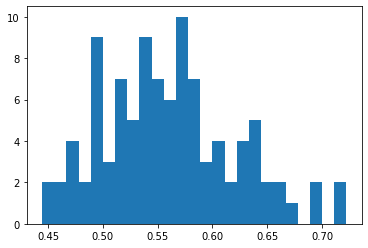

In [9]:
plt.hist(np.reshape(results, (1, -1))[0], bins=25)
plt.show()

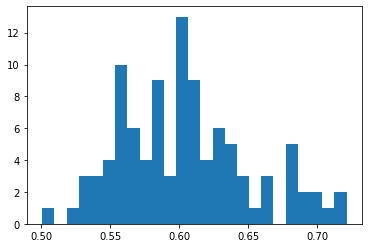

In [10]:
plt.hist(np.reshape(source_results, (1, -1))[0], bins=25)
plt.show()